In [86]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sympy as sp

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Monospace'
plt.rcParams['figure.figsize'] = [8,6]

The Hamiltonian is given by equation (22) from "A Qunatum Engineer's Guide to Superconducting Qubits" and is 
$$H=4E_Cn^2-E_J\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)}\cos(\varphi)$$

In [72]:
nCutoff = 10
nList = np.array((range(-nCutoff, nCutoff+1)))


def Hamiltonian(E_C, E_J, phi_e, d=1, n_cut = nCutoff):
    nList = np.array((range(-n_cut, n_cut+1)))

    nMatrix = np.diag(nList)
    n2Matrix = np.matmul(nMatrix, nMatrix)

    offDiag = np.ones(2*n_cut)
    cosMatrix = 0.5 *(np.diag(offDiag, k = 1) + np.diag(offDiag, k = -1))

    E_kin = 4*E_C*n2Matrix
    E_pot = -E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)*cosMatrix
    return E_kin + E_pot, E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2), nList



In [73]:
H, scale, x = Hamiltonian(1, 50, 0)

eigenvalues, eigenvectors = sc.sparse.linalg.eigs(H, k=5, which="SR")

c:\Users\marku\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


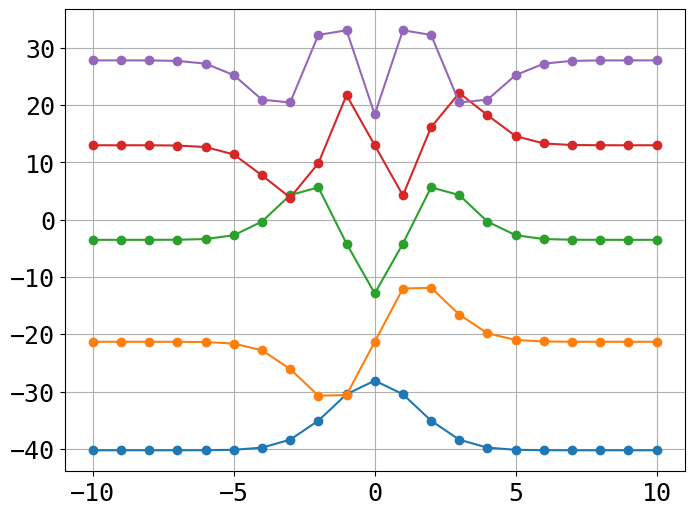

In [87]:
for i in range(5):
    plt.plot(x, eigenvectors[:,i]*20 + eigenvalues.real[i], 'o-')

## Convergence check

In [75]:
def convegence(n_cut):
    nList = np.array((range(-n_cut, n_cut+1)))

    nMatrix = np.diag(nList)
    n2Matrix = np.matmul(nMatrix, nMatrix)

    offDiag = np.ones(2*n_cut)
    cosMatrix = 0.5 *(np.diag(offDiag, k = 1) + np.diag(offDiag, k = -1))

    H, scale, x = Hamiltonian(1, 50, 0, n_cut = n_cut)

    eigenvalues, eigenvectors = sc.sparse.linalg.eigs(H, k=5, which="SR")

    return eigenvalues


In [83]:
converg_arr = np.zeros((12, 5))

for i in range(12):
    eig = convegence(i+3)
    converg_arr[i]=eig


C:\Users\marku\AppData\Local\Temp\ipykernel_7008\901419505.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  converg_arr[i]=eig


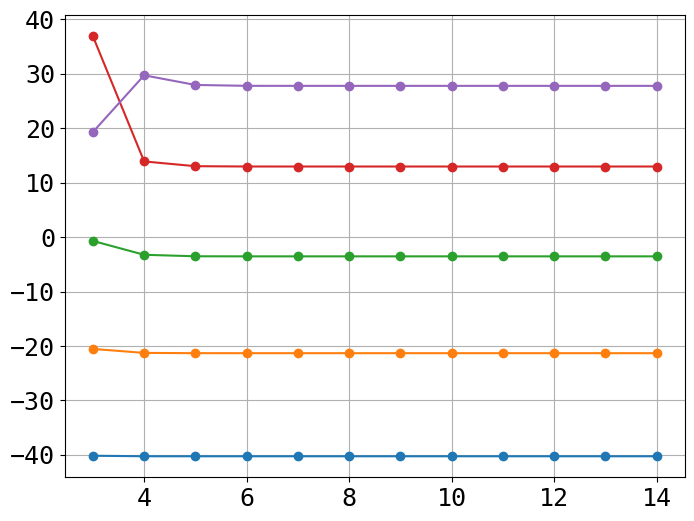

In [85]:
for i in range(5):
    plt.plot(range(3,15), converg_arr[:,i], 'o-')

From this plot is clear to see that $n_{cutoff}=10$ is approriate for the current parameters since the five lowest eigenvalues (which are the ones of interest) converge far earlier than the cut off value.

# E3)

In [90]:
eigenvalues = eigenvalues.real

In [96]:
H_Q = np.zeros((3,3))

H_Q[1,1] = eigenvalues[1]-eigenvalues[0]
H_Q[2,2] = eigenvalues[2]-eigenvalues[0]

nMatrix_subspace = np.diag([0, 1, 2])

np.linalg.eig(H_Q)

(array([ 0.        , 18.94191892, 36.73461482]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [102]:
H_C = np.zeros_like(H_Q)

for i in range(3):
    for j in range(3):
        H_C[i,j] = np.matmul(eigenvectors[:,j], np.matmul(nMatrix, eigenvectors[:,i]))


g1, g2 = H_C[0,1], H_C[1,2]

C:\Users\marku\AppData\Local\Temp\ipykernel_7008\874434295.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  H_C[i,j] = np.matmul(eigenvectors[:,j], np.matmul(nMatrix, eigenvectors[:,i]))


In [104]:
H_C.round(5)

array([[ 0.     ,  1.0878 ,  0.     ],
       [ 1.0878 , -0.     ,  1.49027],
       [ 0.     ,  1.49027,  0.     ]])

In [ ]:
T_ramp = np.pi

t = np.linspace(0, 2*T_ramp, 200)

def envolope(t):
    return np.sin(t)**2

